# Focus Area 3 — Temperature Quality &amp; Microclimates
**Core Objective**: To demonstrate the advantages of high-resolution temperature data in
capturing microclimates and computing derived metrics like PET, for better assessment of heat-
related risks.

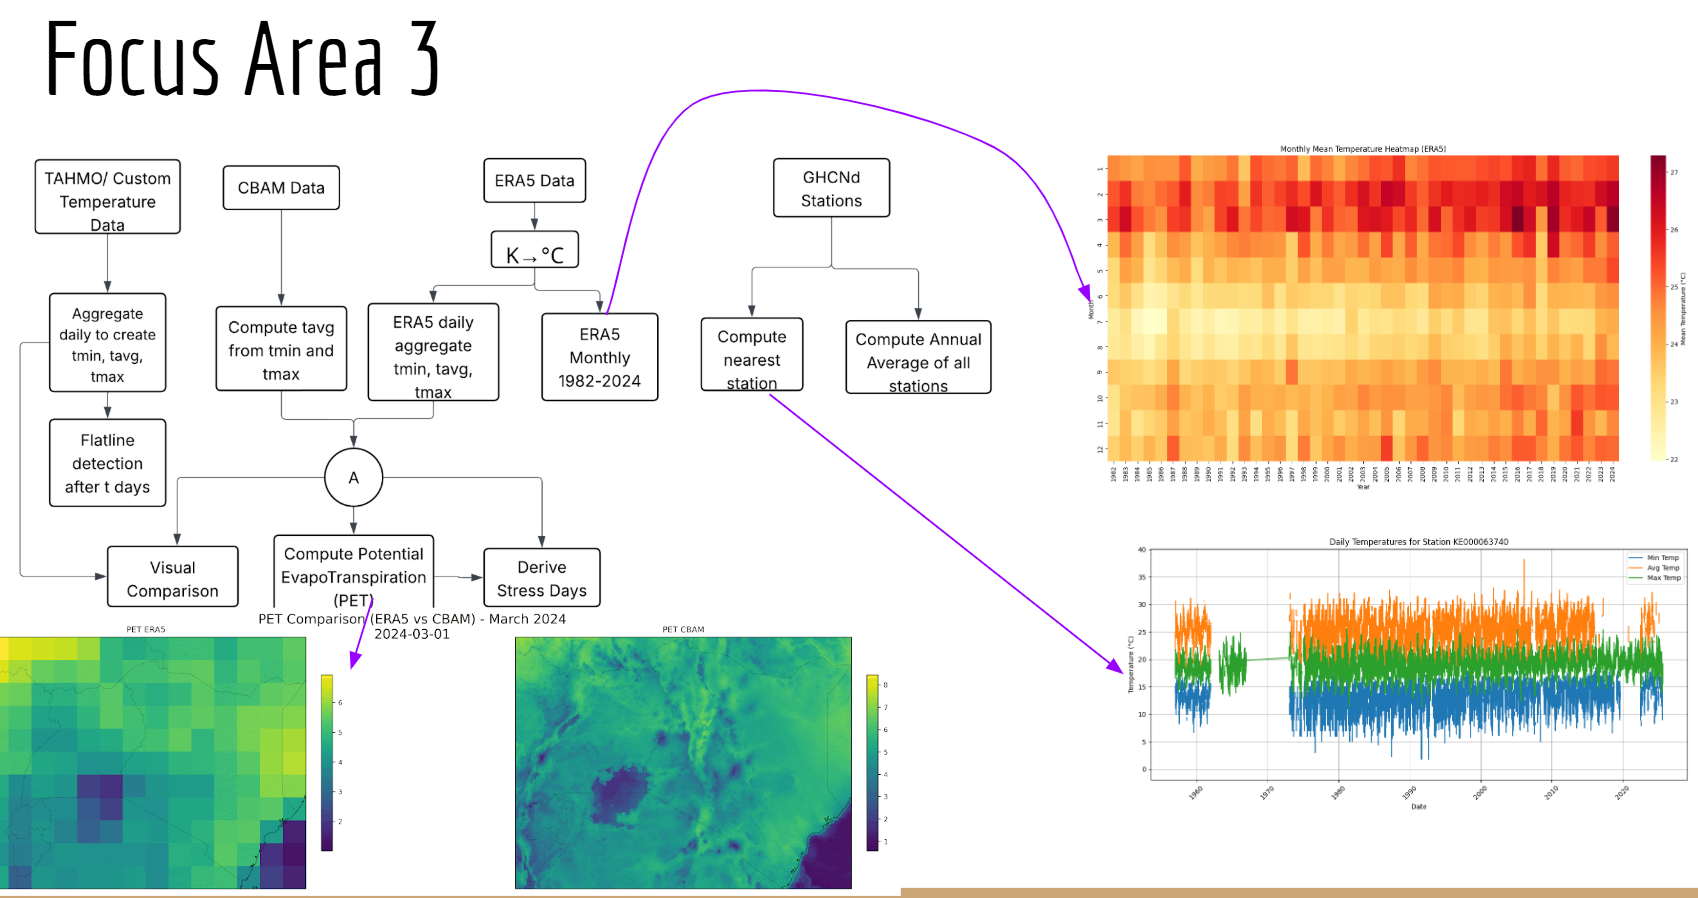

## Extract Temperature data
- GHCN data
- CBAM data
- ERA5 data
<br>

EA: March 2025 heatwave, linking to health impacts.

Use the current location and get the nearest GHCNd weather station and visualise the temperature over the last half a century

Require 2 files
- The Metadata file: Ground_Metadata.csv
- The Ground_station data file: Ground_data.csv

For TAHMO data we shall extract the data during this workshop period.

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>lat</th>
            <th>lon</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Steps Breakdown
- Step 1: Setting up environment and Authentication

- Data Extraction and Loading
    - Step2: Search and Select Region of Interest please use the same region as you did in the previous focus area
    - Step 3: Extract TAHMO temperature data

- Data Processing and QC

    - Step 6:

In [ ]:
# @title Step 1a: Setting up environment installing required Dependencies
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel
import random

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.CBAM_helpers import CBAMClient, extract_cbam_data # CBAM helper functions
from utils.plotting import select, scale, plot_xarray_data, plot_xarray_data2, compare_xarray_datasets, compare_xarray_datasets2 # Plotting helper functionsfrom utils.IMERG_helpers import get_imerg_raw
from utils.ERA5_helpers import era5_data_extracts, era5_var_handling
from google.colab import drive


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import json
import ee
from scipy.stats import pearsonr
import seaborn as sns
from utils.filter_stations import RetrieveData




%matplotlib inline

print("✅ Libraries imported successfully.")

def build_xr_from_stations(ds, stations_metadata, var_name=None):
    # Auto-detect variable if not provided
    if var_name is None:
        candidate_vars = ['total_precipitation', 'total_rainfall', 'precipitation']
        found = [v for v in candidate_vars if v in ds.data_vars]
        if not found:
            raise ValueError(f"None of expected precipitation variable names {candidate_vars} found in dataset vars: {list(ds.data_vars)}")
        var_name = found[0]

    # Determine dimension names
    if {'x', 'y'}.issubset(ds.dims):
        lon_dim, lat_dim = 'x', 'y'
    elif {'lon', 'lat'}.issubset(ds.dims):
        lon_dim, lat_dim = 'lon', 'lat'
    else:
        raise ValueError(f"Dataset dims {list(ds.dims)} do not contain expected (x,y) or (lon,lat).")

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = float(row['lat'])
        lon = float(row['lon'])
        # Skip stations outside domain (quick bounds check)
        if not (ds[lon_dim].min() <= lon <= ds[lon_dim].max() and ds[lat_dim].min() <= lat <= ds[lat_dim].max()):
            continue
        station_da = ds[var_name].sel({lon_dim: lon, lat_dim: lat}, method="nearest")
        station_df = station_da.to_dataframe(name=station_code)
        all_stations_data[station_code] = station_df[station_code]

    combined_df = pd.DataFrame(all_stations_data)
    return combined_df



def plot_temperatures(tmin_df, tavg_df, tmax_df, station_code=None):
    """
    Plots the daily minimum, average, and maximum temperatures for a specified TAHMO station.

    Args:
        tmin_df (pd.DataFrame): DataFrame containing daily minimum temperatures.
        tavg_df (pd.DataFrame): DataFrame containing daily average temperatures.
        tmax_df (pd.DataFrame): DataFrame containing daily maximum temperatures.
        station_code (str, optional): The code of the station to plot. If None, a random station from the DataFrame is plotted.
    """
    if station_code is None:
        station_code = random.choice(tmin_df.columns.tolist())
        print(f"Randomly selected station: {station_code}")
    elif station_code not in tmin_df.columns:
        print(f"Station code {station_code} not found in the data.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(tmin_df.index, tmin_df[station_code], label='Min Temp', linestyle='-')
    plt.plot(tavg_df.index, tavg_df[station_code], label='Avg Temp', linestyle='-')
    plt.plot(tmax_df.index, tmax_df[station_code], label='Max Temp', linestyle='-')

    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Daily Temperatures for Station {station_code}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [2]:
# @title ### Step 1b: Authentication Step
# @markdown This step is used to authenticate you as a user and there will be two popups that will be doing this.
# @markdown 1. **Authentication to Google Drive** - This is where we shall be loading the data after we have extracted it
# @markdown 2. **Authentication to Google Earth Engine** - This will be used to extract the CHIRPS data and any other satellite product we shall be extracting in the future.
# @markdown Please check your email we shared an invitation to our Google Cloud Project that we shall be using to extract the data<br>
# @markdown *PS: In the future, to create your own project, please refer to [Google Cloud's Documentation](https://developers.google.com/earth-engine/guides/access) that shows the step by step breakdown of creating a Google Cloud Project and enabling Google Earth Engine*
# @markdown  Link to configure noncommercial use of Google Earth Engine: https://console.cloud.google.com/earth-engine/configuration <br><br>
# @markdown For this workshop, we have created the ```noaa-tahmo``` project that you can input as your project id<br><br><br>

print("Authenticating to Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive authenticated successfully.")

import ee

# Authenticate and initialise Google Earth Engine
# This will open a link in your browser to grant permissions if necessary.
try:
    print("Authenticating Google Earth Engine. Please follow the instructions in your browser.")
    ee.Authenticate()
    print("✅ Authentication successful.")
except ee.auth.scopes.MissingScopeError:
    print("Authentication scopes are missing. Please re-run the cell and grant the necessary permissions.")
except Exception as e:
    print(f"Authentication failed: {e}")

# Initialize Earth Engine with your project ID
# Replace 'your-project-id' with your actual Google Cloud Project ID
# You need to create an unpaid project manually through the Google Cloud Console
print("\nIf you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console")
print("💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id")
try:
    # It's recommended to use a project ID associated with your Earth Engine account.
    print("\nEnter your Google Cloud Project ID: ")
    project_id = input("")
    ee.Initialize(project=project_id)
    print("✅ Google Earth Engine initialized successfully.")
except ee.EEException as e:
    if "PERMISSION_DENIED" in str(e):
        print(f"Earth Engine initialization failed due to PERMISSION_DENIED.")
        print("Please ensure the Earth Engine API is enabled for your project:")
        print("Enable the Earth Engine API here: https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=elated-capsule-471808-k1")
    else:
        print(f"Earth Engine initialization failed: {e}")
except Exception as e:
    print(f"An unexpected error occurred during initialization: {e}")

Authenticating to Google Drive...
Mounted at /content/drive
✅ Google Drive authenticated successfully.
Authenticating Google Earth Engine. Please follow the instructions in your browser.
✅ Authentication successful.

If you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console
💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id

Enter your Google Cloud Project ID: 
noaa-tahmo
✅ Google Earth Engine initialized successfully.


In [3]:
# @title Step 1c: Pick a start and end date
import ipywidgets as widgets
from IPython.display import display
import datetime

# Create date pickers
start_picker = widgets.DatePicker(
    description='Start Date',
    value=datetime.date(2025, 4, 1),
    disabled=False
)

end_picker = widgets.DatePicker(
    description='End Date',
    value=datetime.date(2025, 9, 30),
    disabled=False
)
display(start_picker, end_picker)

start_date = str(start_picker.value)
end_date = str(end_picker.value)


DatePicker(value=datetime.date(2025, 4, 1), description='Start Date', step=1)

DatePicker(value=datetime.date(2025, 9, 30), description='End Date', step=1)


A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
    "location_keys": "",
    "cbam_username" : "",
    "cbam_password" : ""

}


In [ ]:
# @title Step 1d: Please upload the provided config file
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"✅ File '{file_name}' uploaded successfully.")

# Loading the config file and parsing from uploaded incase it comes with a different name
import json
with open(file_name, 'r') as f:
    config = json.load(f)

In [ ]:
# @title Step 2: Search and Select Region of Interest please use the same region as you did in the previous focus area
# @markdown Enter the name of a country, region, or place in Africa. <br>
# @markdown The Google Maps API will be used to fetch its geometry, bounding box, and show the polygon on a map.<br>
# @markdown We highly recommend to use a region within the East Africa for everything to run smoothly

import json
import folium

# print("Loading config file...")
# Load config file
# Load API key
with open('/content/config.json', 'r') as f:
    config = json.load(f)

location_key = config['location_keys']  # Google Maps API key

# --- Helper functions ---
def xmin_ymin_xmax_ymax(polygon):
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    return min(lons), min(lats), max(lons), max(lats)

def fetch_region(query):
    region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    print(f"✅ Selected: {query}")
    print(f"Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
    return region_geom, (xmin, ymin, xmax, ymax)

def show_region_polygon(polygon):
    # Center map on polygon
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=6)
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon],
        color="blue",
        weight=2,
        fill=True,
        fill_opacity=0.3,
    ).add_to(m)
    return m

# --- Main logic ---
region_query = input("🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti): ")

try:
    region_geom, bbox = fetch_region(region_query)
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    m = show_region_polygon(region_geom)  # draw polygon, not bbox
    display(m)
except Exception as e:
    print(f"❌ Could not fetch geometry for '{region_query}': {e}")
    print("🔁 Please re-run the cell and enter a different region.")

# .lower
region_query = region_query.lower()

start_date = "2025-04-01"
end_date = "2025-05-31"

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)
# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

In [ ]:
# @title ERA5 builder
import ee
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import math
import datetime
import io
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import HTML, display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from filter_stations import retreive_data, Filter
import base64
import json
import requests
import datetime
from utils.helpers import get_region_geojson, df_to_xarray



def extract_era5_daily(start_date_str, end_date_str, bbox=None, polygon=None, era5_l=False, aggregate='mean'):
    """
    Extract ERA5 reanalysis data (daily aggregated) from Google Earth Engine for a given bounding box or polygon and time range.
    The extraction is performed on a daily basis by aggregating hourly images (using the mean) for each day.
    For each day, the function retrieves the ERA5 HOURLY images, aggregates them, adds pixel coordinate bands (longitude
    and latitude), and uses sampleRectangle to extract a grid of pixel values. The results for each variable (band) are then
    organized into pandas DataFrames with the following columns:
      - date: The daily timestamp (ISO formatted)
      - latitude: The latitude coordinate of the pixel center
      - longitude: The longitude coordinate of the pixel center
      - value: The aggregated pixel value for that variable

    Args:
        start_date_str (str): Start datetime in ISO format, e.g., '2020-01-01T00:00:00'.
        end_date_str (str): End datetime in ISO format, e.g., '2020-01-02T00:00:00'.
        bbox (list or tuple, optional): Bounding box specified as [minLon, minLat, maxLon, maxLat]. Default is None.
        polygon (list, optional): Polygon specified as a list of coordinate pairs (e.g., [[lon, lat], ...]).
                                  If provided, the polygon geometry will be used instead of the bounding box.
                                  Default is None.
        era5_l (bool, optional): If True, use ERA5_LAND instead of ERA5. Default is False.
        aggregate (str, optional): Aggregation method ('mean' or 'sum' or 'min', or 'max'). Default is 'mean'.

    Returns:
        dict: A dictionary where keys are variable (band) names and values are pandas DataFrames containing
              the daily aggregated data.
    """
    # Convert input datetime strings to Python datetime objects.
    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%dT%H:%M:%S')
    end_date   = datetime.datetime.strptime(end_date_str, '%Y-%m-%dT%H:%M:%S')

    # Define the geometry: Use polygon if provided, otherwise use bbox.
    if polygon is not None:
        region = ee.Geometry.Polygon(polygon)
    elif bbox is not None:
        region = ee.Geometry.Rectangle(bbox)
    else:
        raise ValueError("Either bbox or polygon must be provided.")

    # Define a scale in meters corresponding approximately to 0.25° (at the equator, 1° ≈ 111320 m).
    scale_m = 27830

    # This dictionary will accumulate extracted records for each variable (band).
    results = {}

    # Loop over each day in the specified time range.
    current = start_date
    while current < end_date:
        next_day = current + datetime.timedelta(days=1)

        # Format the current time window in ISO format.
        t0_str = current.strftime('%Y-%m-%dT%H:%M:%S')
        t1_str = next_day.strftime('%Y-%m-%dT%H:%M:%S')

        print(f"Processing {t0_str} to {t1_str}")

        # If ER5 Land (0.1) or ERA5 (0.25)
        if era5_l:
            # Get the ERA5 Land hourly image collection for the current day.
            collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
                            .filterDate(ee.Date(t0_str), ee.Date(t1_str))
        else:
            # Get the ERA5 hourly image collection for the current day.
            collection = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                            .filterDate(ee.Date(t0_str), ee.Date(t1_str))

        # Aggregate the hourly images into a single daily image using the mean.
        if aggregate == 'mean':
            image = collection.mean()
        elif aggregate == 'sum':
            image = collection.sum()
        elif aggregate == 'min':
            image = collection.min()
        elif aggregate == 'max':
            image = collection.max()
        else:
            raise ValueError(f"Invalid aggregation method: {aggregate} can either be sum, min, max or mean")

        # Add bands containing the pixel longitude and latitude.
        image = image.addBands(ee.Image.pixelLonLat())

        # Use sampleRectangle to extract a grid of pixel values over the region.
        region_data = image.sampleRectangle(region=region, defaultValue=0).getInfo()

        # The pixel values for each band are in the "properties" dictionary.
        props = region_data['properties']

        # Extract the coordinate arrays from the added pixelLonLat bands.
        lon_array = props['longitude']  # 2D array of longitudes
        lat_array = props['latitude']   # 2D array of latitudes

        # Determine the dimensions of the extracted grid.
        nrows = len(lon_array)
        ncols = len(lon_array[0]) if nrows > 0 else 0

        # Identify the names of the bands that hold ERA5 variables, excluding the coordinate bands.
        band_names = [key for key in props.keys() if key not in ['longitude', 'latitude']]

        # Initialize results lists for each band if not already present.
        for band in band_names:
            if band not in results:
                results[band] = []

        # Loop over each pixel in the grid.
        for i in range(nrows):
            for j in range(ncols):
                pixel_lon = lon_array[i][j]
                pixel_lat = lat_array[i][j]
                # For each ERA5 variable band, extract the pixel value and create a record.
                for band in band_names:
                    pixel_value = props[band][i][j]
                    record = {
                        'date': t0_str,  # daily timestamp as a string
                        'latitude': pixel_lat,
                        'longitude': pixel_lon,
                        'value': pixel_value
                    }
                    results[band].append(record)

        # Advance to the next day.
        current = next_day

    # Convert the accumulated results for each band into pandas DataFrames.
    dataframes = {band: pd.DataFrame(records) for band, records in results.items()}
    return dataframes



## Data Extraction

In [ ]:
# @title Step 3: Extract the TAHMO temperature 5 minute data for 2024 and extract the tmin, tavg and tmax
# Load TAHMO EAC stations previously extracted
eac_metadata = pd.read_csv("/content/drive/MyDrive/Datasets/ground/eac_stations.csv")
eac_metadata = eac_metadata[['code',
                             'location.latitude',
                             'location.longitude']].rename(columns={'location.latitude': 'lat',
                                                                    'location.longitude': 'lon'})

# Load the config file
with open('/content/config (1).json', 'r') as f:
    config = json.load(f)

# Set the api key and secret
api_key = config['apiKey']
api_secret = config['apiSecret']


# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)


# Get the temperature data for the EAC stations in 5min intervals
eac_temp = rd.multiple_measurements(stations_list=eac_metadata['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['te'],
                                     csv_file = "/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_temp_march_2024",
                                     aggregate='5min'
                                     )


# Aggregate the values to get the min, mean and max for the day
tahmo_eac_tmin = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='min'
)
tahmo_eac_tavg = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='mean'
)
tahmo_eac_tmax = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='max'
)


plot_temperatures(tahmo_eac_tmin, tahmo_eac_tavg, tahmo_eac_tmax)


# Save the variables
tahmo_eac_tmin.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmin_march_2024.csv", index=True)
tahmo_eac_tavg.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tavg_march_2024.csv", index=True)
tahmo_eac_tmax.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmax_march_2024.csv", index=True)

### GHCNd stations
- Available globally

In [ ]:
# @title Extract GHCNd weather stations
# @markdown They are distributed globally
!git clone https://github.com/scotthosking/get-station-data.git

import sys

sys.path.append('get-station-data')

from get_station_data import ghcnd
from get_station_data.util import nearest_stn

from utils.GHCN_stations import subset_stations_in_bbox, get_nearest_wmo_station, subset_noaa_stations_by_country, subset_weather_data_by_variable # GHCN station helper functions


%matplotlib inline

@markdown Plot stations on a map
import folium

def plot_stations_folium(dataframes, colors=None, wmo=True):
    """
    Plot stations from one or more dataframes on a Folium map.

    Each dataframe must have 'location.latitude' and 'location.longitude' columns.
    'colors' is a list specifying marker colors for each dataframe respectively.
    """
    if colors is None:
        colors = ["blue", "red", "green", "purple", "orange"]

    # Create a base map; you can adjust the initial location/zoom as needed
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Add markers for each dataframe
    for df, color in zip(dataframes, colors):
        for _, row in df.iterrows():
          if wmo:
              folium.Marker(
                  location=[row["lat"], row["lon"]],
                  tooltip=str(row["station"]),   # <--- Pass the tooltip here
                  icon=folium.Icon(color=color)
              ).add_to(m)
          else:
              folium.Marker(
                  location=[row["location.latitude"], row["location.longitude"]],
                  tooltip=str(row["code"]),   # <--- Pass the tooltip here
                  icon=folium.Icon(color=color)
              ).add_to(m)

    return m


stn_md = ghcnd.get_stn_metadata()
# stn_md

# Format the data rename lat and lon to latitude and longitude
# stn_md = stn_md.rename(columns={'lat': 'latitude', 'lon': 'longitude'})


wmo_ke_stations = subset_noaa_stations_by_country(stn_md, 'KE')
wmo_ug_stations = subset_noaa_stations_by_country(stn_md, 'UG')
wmo_rw_stations = subset_noaa_stations_by_country(stn_md, 'RW')

# concatenate eac stations
eac_wmo_stations = pd.concat([wmo_ke_stations, wmo_ug_stations, wmo_rw_stations])

plot_stations_folium([wmo_ke_stations, wmo_ug_stations, wmo_rw_stations])

# Get the data
eac_wmo_data = ghcnd.get_data(eac_wmo_stations)

eac_wmo_data[eac_wmo_data.station == 'KEM00063741']

In [ ]:
# @title Visualise WMO data nearest to you

# Nairobi coordinates
nairobi_coords = -1.293295, 37.822163
kigali_coords = -1.944559, 30.061947
kampala_coords = 0.315646, 32.581673

''' feel free to add your own coords'''
my_coords = ...

# Get the nearest station
nearest_stn(stn_md, nairobi_coords[1], nairobi_coords[0])


# method given coordinates computes the nearest station together with the data
def get_nearest_wmo_station_data(stn_md, eac_wmo_data, lat, lon):
  import haversine as hs
  # get the nearest data
  nearest_station = nearest_stn(stn_md, lon, lat)

  # compute the distance
  # Extract scalar lat and lon values from the Series
  nearest_lat = nearest_station['lat'].iloc[0]
  nearest_lon = nearest_station['lon'].iloc[0]
  distance = hs.haversine((lat, lon), (nearest_lat, nearest_lon))
  print(nearest_station['station'].iloc[0])

  # get the data from the station id
  soi = eac_wmo_data[eac_wmo_data.station == nearest_station['station'].iloc[0]]

  # Return the distance and the data
  return distance, soi

# write a method to extract tmin, tmax, tvg
def extract_tmin_tmax_tvg(soi, plot=False):
  tavg = subset_weather_data_by_variable(soi, 'TAVG', pivot=True)
  tmin = subset_weather_data_by_variable(soi, 'TMIN', pivot=True)
  tmax = subset_weather_data_by_variable(soi, 'TMAX', pivot=True)

  if plot:
    plot_temperatures(tmin, tmax, tavg)
  else:
    return tmin, tmax, tavg

distance, soi = get_nearest_wmo_station_data(stn_md, eac_wmo_data, nairobi_coords[0], nairobi_coords[1])

extract_tmin_tmax_tvg(soi, plot=True)

eac_wmo_tmin, eac_wmo_tmax, eac_wmo_tavg = extract_tmin_tmax_tvg(eac_wmo_data)

#### Compare the temperature of TAHMO station/WMO station with the Met Agency data

In [ ]:
# Compare the temperatures

In [ ]:
# @title Extract CBAM temperature data (2018 -2024)
# @markdown This data takes a while to extract and we shall be giving you the extracted data
# Define parameters as shown in the docs
product = 'cbam_historical_analysis'
attribs = ["max_temperature", "min_temperature"]
# start_date = '2012-01-01'
# end_date = '2023-12-31'
eac_bbox = [xmin, ymin, xmax, ymax]
print(eac_bbox)

# Create a client and extract data
client = CBAMClient('config.json')
cbam_data = extract_cbam_data(start_date='2012-01-01', end_date='2024-12-31',
                         attributes=attribs, cbam_client=client, bbox=eac_bbox,
                         output_type='netcdf')


In [ ]:
# @title ERA5 extract data from 1982 -2024



import ee
import io
import os
import tempfile
import requests
import datetime
import numpy as np
import xarray as xr
import rasterio
from rasterio.io import MemoryFile
from rasterio.transform import xy as rio_xy

# Authenticate / initialize once (uncomment in interactive runtime)
# ee.Authenticate()
# ee.Initialize()

def era5_yearly_to_inmemory_netcdf(
    variable,
    start_year=1982,
    end_year=None,
    region_ee_geometry=None,
    dataset='ERA5_LAND',   # 'ERA5' or 'ERA5_LAND'
    cadence='monthly',       # 'hourly' or 'daily' or 'monthly'
    scale=None,            # meters (defaults used below)
    crs='EPSG:4326',
    save_local_copy=False, # also save .nc to local disk (path returned)
    local_folder='./',
    max_images_per_year=4000  # safety cutoff
):
    """
    For each year in [start_year, end_year], download the ERA5 images in that year,
    aggregate them according to the specified cadence, build a time-x-y-xarray dataset
    and write a NetCDF file for that year, then return the NetCDF as an in-memory
    BytesIO object.

    Returns:
        dict: { year (int) : { 'nc_bytes': io.BytesIO, 'local_path': str or None } }
    """

    if end_year is None:
        end_year = datetime.datetime.utcnow().year

    # Dataset selection and default scale (meters)
    ds_upper = dataset.upper()
    if ds_upper == 'ERA5_LAND' or ds_upper == 'ERA5-LAND' or ds_upper == 'ERA5LAND':
        coll_hourly = 'ECMWF/ERA5_LAND/HOURLY'
        coll_daily = 'ECMWF/ERA5_LAND/DAILY_AGGR'
        default_scale = 11132
    elif ds_upper == 'ERA5':
        coll_hourly = 'ECMWF/ERA5/HOURLY'
        coll_daily = 'ECMWF/ERA5/DAILY'
        default_scale = 27830
    else:
        raise ValueError("dataset must be 'ERA5' or 'ERA5_LAND'")

    if scale is None:
        scale = default_scale

    if region_ee_geometry is None:
        raise ValueError("region_ee_geometry (an ee.Geometry) is required (keep it small!)")

    # turn region into a geojson / coordinates object for getDownloadURL
    # getInfo() here calls the server once
    region_geojson = region_ee_geometry.getInfo()

    results = {}

    for year in range(start_year, end_year + 1):
        print(f"\n--- Processing year {year} ---")
        start_date_year = f'{year}-01-01'
        end_date_year = f'{year+1}-01-01'

        if cadence == 'hourly':
            coll = ee.ImageCollection(coll_hourly).filterDate(start_date_year, end_date_year).select(variable)
        elif cadence == 'daily':
            coll = ee.ImageCollection(coll_daily).filterDate(start_date_year, end_date_year).select(variable)
        elif cadence == 'monthly':
             # Process month by month for monthly aggregation
            monthly_images = []
            current_month_start = datetime.datetime.strptime(start_date_year, '%Y-%m-%d')
            while current_month_start.year == year:
                next_month_start = (current_month_start.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)
                coll_hourly_month = ee.ImageCollection(coll_hourly).filterDate(current_month_start, next_month_start).select(variable)
                monthly_image = coll_hourly_month.mean() # Aggregate hourly to monthly mean
                monthly_images.append(monthly_image.set('system:time_start', ee.Date(current_month_start)))
                current_month_start = next_month_start
            coll = ee.ImageCollection(monthly_images)
        else:
            raise ValueError("cadence must be 'hourly', 'daily', or 'monthly'")


        try:
            n_images = int(coll.size().getInfo())
        except Exception as e:
            raise RuntimeError(f"Could not fetch collection size for {year}: {e}")

        if n_images == 0:
            print(f"No images found for {year} (variable '{variable}', cadence '{cadence}'). Skipping.")
            continue

        if n_images > max_images_per_year and cadence != 'monthly': # Allow more images for monthly aggregation
             raise RuntimeError(f"Year {year} has {n_images} images > max_images_per_year ({max_images_per_year}). Aborting for safety.")

        print(f"Found {n_images} images for {year}. Downloading each to memory (this may be slow).")

        # Build lists to stack
        img_arrays = []
        times = []
        ref_shape = None
        ref_transform = None
        ref_crs = None

        # Convert collection to server list and iterate
        coll_list = coll.toList(n_images)

        for i in range(n_images):
            ee_img = ee.Image(coll_list.get(i))
            # time string
            try:
                time_start_ms = ee.Date(ee_img.get('system:time_start')).getInfo()['value']
                time_str = datetime.datetime.fromtimestamp(time_start_ms / 1000.0).strftime('%Y-%m-%d')
            except Exception:
                # fallback: use index-based date
                time_str = f'{year}-unknown-{i}'
            print(f"  - image {i+1}/{n_images} date {time_str} ...", end=' ', flush=True)

            # Request a GeoTIFF download URL (format GEO_TIFF to get raw .tif bytes)
            params = {
                'bands': [variable],
                'region': region_geojson,   # geojson-like mapping or coordinates (small)
                'scale': int(scale),
                'format': 'GEO_TIFF',
                'filePerBand': False
            }

            try:
                url = ee_img.getDownloadURL(params)
            except Exception as e:
                raise RuntimeError(f"getDownloadURL failed for {year} image idx {i}: {e}")

            # Download bytes (may be zipped or raw GeoTIFF depending on params; we asked GEO_TIFF)
            r = requests.get(url, timeout=600)
            if r.status_code != 200:
                raise RuntimeError(f"HTTP error {r.status_code} when downloading image: {r.text[:200]}")

            # Load into rasterio MemoryFile
            with MemoryFile(r.content) as mem:
                with mem.open() as src:
                    arr = src.read(1)           # single-band image
                    transform = src.transform
                    crs_src = src.crs
                    h, w = src.height, src.width

            # check shape consistency
            if ref_shape is None:
                ref_shape = (h, w)
                ref_transform = transform
                ref_crs = crs_src
            else:
                if (h, w) != ref_shape:
                    raise RuntimeError(f"Image {i} shape {h,w} differs from first image shape {ref_shape}. Reprojection/resampling not implemented - aborting.")

            img_arrays.append(arr)
            times.append(np.datetime64(time_str))
            print("OK")

        # Stack into ndarray (time, y, x)
        data_stack = np.stack(img_arrays, axis=0)  # shape (time, H, W)
        print(f"Stacked data: {data_stack.shape}")

        # Build coordinate vectors from transform
        height, width = ref_shape
        # x coords (cols)
        xs = np.array([rio_xy(ref_transform, 0, col, offset='center')[0] for col in range(width)])
        # y coords (rows) - note rasterio returns y per (row, col); rows increase downward
        ys = np.array([rio_xy(ref_transform, row, 0, offset='center')[1] for row in range(height)])

        # xarray DataArray
        da = xr.DataArray(
            data_stack,
            dims=('time', 'y', 'x'),
            coords={'time': times, 'y': ys, 'x': xs},
            name=variable
        )

        ds = xr.Dataset({variable: da})
        ds.attrs['source'] = f"GEE {coll_daily} ({dataset})" # Note: still using daily collection ID in source attr
        # Convert region_geojson to a string for NetCDF compatibility
        ds.attrs['region'] = json.dumps(region_geojson)
        ds.attrs['scale_m'] = scale

        # Persist to a temporary netCDF file, then load bytes into memory
        tmpf = tempfile.NamedTemporaryFile(suffix=f"_{variable}_{year}_{cadence}.nc", delete=False)
        tmpf.close()
        try:
            ds.to_netcdf(tmpf.name, engine='netcdf4')
        except Exception as e:
            os.unlink(tmpf.name)
            raise RuntimeError(f"Failed to write NetCDF for year {year}: {e}")

        # Read bytes into memory BytesIO
        with open(tmpf.name, 'rb') as f:
            nc_bytes = f.read()

        # Optionally save a local persistent copy
        local_path = None
        if save_local_copy:
            os.makedirs(local_folder, exist_ok=True)
            local_path = os.path.join(local_folder, f"{variable}_{year}_{cadence}.nc")
            with open(local_path, 'wb') as f:
                f.write(nc_bytes)

        # Cleanup temp file
        os.unlink(tmpf.name)

        results[year] = {'nc_bytes': io.BytesIO(nc_bytes), 'local_path': local_path}

        print(f"Year {year} done: NetCDF in memory ({len(nc_bytes)/1e6:.2f} MB).")

    return results


roi = ee.Geometry.Polygon(eac_region)

out = era5_yearly_to_inmemory_netcdf(
    variable='temperature_2m',
    start_year=1982,
    end_year=2024,
    region_ee_geometry=roi,
    dataset='ERA5',        # or 'ERA5_LAND'
    cadence='monthly',
    scale=27830,           # use native-ish scale for ERA5 (meters)
    save_local_copy=False
)

# Access the NetCDF bytes for 2023:
nc_bytesio = out[2023]['nc_bytes']      # io.BytesIO
# To load into xarray directly from memory:
nc_bytesio.seek(0)
ds = xr.open_dataset(nc_bytesio)
print(ds)


## Data Processing

1. Ground (GHCN/TAHMO/your station) vs CBAM/ERA5
2. PET comparison plot (CBAM vs ERA5)
3. Count of heat/agri stress days --- Plot of the heat exchange

In [ ]:
# @title Load TAHMO temperature data
# Load the tmin, tmax, tavg files
tahmo_eac_tmin = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmin_march_2024.csv", index_col=0)
tahmo_eac_tmax = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmax_march_2024.csv", index_col=0)
tahmo_eac_tavg = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tavg_march_2024.csv", index_col=0)


In [ ]:
# @title Load ERA5 Data Monthly
era5_march = xr.open_dataset("/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/era5/era5_temperature_agg_march_2024.nc")

# rename lat and lon to x and y
era5_march = era5_march.rename({'lat': 'y', 'lon': 'x'})

era5_march

plot_xarray_data2(
    xarray_ds=era5_march,
    fig_title="Temperature over EAC (KE, RW, UG) Region ERA5",
    columns=["min_temperature", "avg_temperature", "max_temperature"],
    plot_size=4,
    bbox=[xmin, ymin, xmax, ymax],
    save=True
)

In [ ]:
# @title Load ERA5 1982-2024

era5_monthly = xr.open_dataset("/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/era5/era5_temperature_monthly_1982_2024_combined.nc")
# rename x and y to latitude and longitude
era5_monthly = era5_monthly.rename({'x': 'longitude', 'y': 'latitude'})

# Subtract 273.15 to convert from Kelvin to degrees celsius
era5_monthly['temperature_2m'] = era5_monthly['temperature_2m'] - 273.15

# Convert time to datetime objects
era5_monthly['time'] = pd.to_datetime(era5_monthly['time'].values)

plot_xarray_data2(
    xarray_ds=era5_monthly,
    fig_title="ERA5 Temperature Analysis in East Africa",
    columns=["temperature_2m"],
    plot_size=7,
    bbox=[xmin, ymin, xmax, ymax],
)

In [ ]:
# @title Load CBAM Data
# Data from 2018-2024
cbam_eac = xr.open_dataset('/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/CBAM_temp2018_2024.nc')

# Subset for march 2024
# cbam_eac = cbam_eac.sel(date=slice('2024-03-01', '2024-03-31'))

# # Agreegate the data from daiy to monthly
# cbam_eac_monthly = cbam_eac.resample(time='M').mean()

# cbam_eac_monthly

del cbam_eac

# select the month of march 2024
cbam_eac_march = cbam_eac.sel(date=slice('2024-03-01', '2024-03-31'))
# compute the avg_temperature from the min and max temperature by computing the sum and dividing by 2
cbam_eac_march['avg_temperature'] = (cbam_eac_march['max_temperature'] + cbam_eac_march['min_temperature']) / 2

In [ ]:
# @title ERA5 and CBAM Comparison
# rename date to time
cbam_eac_march = cbam_eac_march.rename({'date': 'time'})
# rename cbam lat lon to x y
cbam_eac_march = cbam_eac_march.rename({'lat': 'y', 'lon': 'x'})

datasets = [era5_march['max_temperature'].to_dataset(), cbam_eac_march['max_temperature'].to_dataset()]

compare_xarray_datasets2(
    datasets,
    labels=['max_temperature ERA5', 'max_temperature CBAM'],
    fig_title='Temp comparison',
    bboxes=[[xmin, ymin, xmax, ymax], [xmin, ymin, xmax, ymax]],
    save=True
)

In [ ]:
# @title PET Comparison
# @markdown Potential Evapotranspiration

import numpy as np

def pet_hargreaves(tmin, tmax, tmean, Ra=15.0):
    dtr = np.maximum(tmax - tmin, 0)
    return 0.0023 * Ra * (tmean + 17.8) * np.sqrt(dtr)

def rmse(a,b): return float(np.sqrt(np.nanmean((np.asarray(a)-np.asarray(b))**2)))

pet_cbam = pet_hargreaves(cbam_eac_march['min_temperature'], cbam_eac_march['max_temperature'], cbam_eac_march['avg_temperature'])
# Assign a name to the DataArray before converting to Dataset
pet_cbam = pet_cbam.to_dataset(name='pet')

pet_era5 = pet_hargreaves(era5_march['min_temperature'], era5_march['max_temperature'], era5_march['avg_temperature'])
pet_era5 = pet_era5.to_dataset(name='pet')

# Compare PET from ERA5 and CBAM
compare_xarray_datasets2(
    [pet_era5, pet_cbam],
    labels=['PET ERA5', 'PET CBAM'],
    fig_title='PET Comparison (ERA5 vs CBAM) - March 2024',
    bboxes=[[xmin, ymin, xmax, ymax], [xmin, ymin, xmax, ymax]],
    save=True
)

In [ ]:
# @title Computing stress
stress_cbam = (pet_cbam>5) &(cbam_eac_march['max_temperature']>32)
stress_era5 = (pet_era5>5) &(era5_march['max_temperature']>32)

# get the stress days
print("Heat/Agri stress days (CBAM): ", )

### Examining the Heat change over the years

1. Use WMO Stations and get the overall heat in the nearest station
2. Look at all the stations maximum temperature reached over the years as a heatmap
3. Set your own coordinates for your location in East Africa (KE, UG, RW) to get the data
4. Get the monthly ERA5 data and visualise a similar heatmap
5. Visualise the heat change comparison of the 2

In [ ]:
# method to create a heatmap of maximum temperature for WMO stations
def plot_wmo_heatmap(annual_max_temp_stations, fig_title="Annual Maximum Temperature Heatmap (WMO Stations)"):
    """
    Plots a heatmap of annual maximum temperature for WMO stations.

    Args:
        annual_max_temp_stations (pd.DataFrame): DataFrame with annual maximum temperatures per station.
        fig_title (str): Title of the heatmap.
    """
    # localise to None date
    # annual_max_temp_stations = annual_max_temp_stations.T
    annual_max_temp_stations.index = pd.to_datetime(annual_max_temp_stations.index)
    annual_max_temp_stations = annual_max_temp_stations.tz_localize(None)
    annual_max_temp_stations = annual_max_temp_stations.T

    plt.figure(figsize=(15, 8))
    sns.heatmap(annual_max_temp_stations,
                cmap='YlOrRd',
                cbar_kws={'label': 'Maximum Temperature (°C)'}) # Fixed cbar_label
    plt.title(fig_title)
    plt.xlabel('Year')
    plt.ylabel('Station')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# method to create a heatmap of temperature for ERA5 monthly data
def plot_era5_heatmap(era5_monthly_data, variable='temperature_2m', fig_title="Monthly Temperature Heatmap (ERA5)"):
    """
    Plots a heatmap of monthly temperature for ERA5 data.

    Args:
        era5_monthly_data (xr.Dataset): Xarray Dataset containing monthly ERA5 temperature data.
        variable (str): The variable to plot from the ERA5 dataset.
        fig_title (str): Title of the heatmap.
    """
    # Assuming the ERA5 data has dimensions 'time', 'latitude', 'longitude'
    monthly_mean_temp = era5_monthly_data[variable].mean(dim=['latitude', 'longitude'])

    # Convert to pandas Series for plotting
    monthly_mean_temp_series = monthly_mean_temp.to_series()

    # Create a MultiIndex from the time index for unstacking
    monthly_mean_temp_series.index = pd.MultiIndex.from_arrays([
        monthly_mean_temp_series.index.year,
        monthly_mean_temp_series.index.month
    ], names=['year', 'month'])


    # Reshape for heatmap (Month x Year)
    heatmap_data = monthly_mean_temp_series.unstack().T

    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Mean Temperature (°C)'}) # Fixed cbar_label
    plt.title(fig_title)
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.tight_layout()
    plt.show()

# method to visualize heat change comparison (this will depend on the specific comparison needed)
def compare_heatmaps(heatmap1_data, heatmap2_data, label1, label2, fig_title="Heatmap Comparison"):
    """
    Visualizes the comparison of two heatmaps.

    Args:
        heatmap1_data (pd.DataFrame): Data for the first heatmap.
        heatmap2_data (pd.DataFrame): Data for the second heatmap.
        label1 (str): Label for the first heatmap.
        label2 (str): Label for the second heatmap.
        fig_title (str): Title for the comparison plot.
    """
    # This is a placeholder. Actual comparison visualization will depend on the data structure and desired comparison.
    print(f"Comparison visualization between {label1} and {label2} needs to be implemented based on the specific comparison method (e.g., difference, correlation).")
    # Example: Plotting the difference (requires both heatmaps to have the same structure)
    # if heatmap1_data.shape == heatmap2_data.shape:
    #     difference_heatmap = heatmap1_data - heatmap2_data
    #     plt.figure(figsize=(15, 8))
    #     sns.heatmap(difference_heatmap, cmap='coolwarm', center=0, cbar_label='Temperature Difference (°C)')
    #     plt.title(f'{fig_title} (Difference: {label1} - {label2})')
    #     plt.xlabel('Year')
    #     plt.ylabel('Month/Station') # Adjust label based on heatmap structure
    #     plt.tight_layout()
    #     plt.show()
    # else:
    #     print("Heatmaps have different shapes and cannot be directly subtracted for difference visualization.")

# Set your own coordinates (example using Nairobi coordinates)
my_lat = nairobi_coords[0]
my_lon = nairobi_coords[1]

# Use WMO Stations and get the overall heat in the nearest station
distance, nearest_wmo_data = get_nearest_wmo_station_data(stn_md, eac_wmo_data, my_lat, my_lon)

# Extract TMIN, TMAX, TAVG for the nearest station
nearest_wmo_tmin, nearest_wmo_tmax, nearest_wmo_tavg = extract_tmin_tmax_tvg(nearest_wmo_data)

print("\nTemperature data for the nearest WMO station:")
display(nearest_wmo_tavg.head())


# Visualise the heat change comparison of the 2
# For comparison, let's use the mean annual maximum temperature from WMO stations
# and the mean annual temperature from ERA5
wmo_mean_annual_max = annual_max_temp_stations.mean(axis=1).to_frame(name='WMO Mean Annual Max Temp')

# For ERA5, let's calculate the mean annual temperature over the region
era5_mean_annual = era5_monthly['temperature_2m'].mean(dim=['latitude', 'longitude']).resample(time='Y').mean().to_series().to_frame(name='ERA5 Mean Annual Temp')

# Align the dataframes by year
comparison_df = pd.concat([wmo_mean_annual_max, era5_mean_annual], axis=1)


# Look at all the stations maximum temperature reached over the years as a heatmap
# Ensure annual_max_temp_stations is calculated (if not already)
if 'annual_max_temp_stations' not in locals():
    annual_max_temp_stations = eac_wmo_tmax.resample('Y').max()

plot_wmo_heatmap(annual_max_temp_stations)
# Plot the comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(ax=plt.gca())
plt.title('Mean Annual Temperature Comparison (WMO vs ERA5)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Call the compare_heatmaps function (placeholder)
# compare_heatmaps(annual_max_temp_stations, heatmap_data, 'WMO Annual Max Temp', 'ERA5 Monthly Mean Temp')

# @title Plot ERA5 Heatmap over time
# Ensure era5_monthly is loaded and processed (if not already)
if 'era5_monthly' not in locals():
    era5_monthly = xr.open_dataset("/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/era5/era5_temperature_monthly_1982_2024_combined.nc")
    era5_monthly = era5_monthly.rename({'x': 'longitude', 'y': 'latitude'})
    era5_monthly['temperature_2m'] = era5_monthly['temperature_2m'] - 273.15
    era5_monthly['time'] = era5_monthly['time'].dt.strftime('%Y-%m')

plot_era5_heatmap(era5_monthly, variable='temperature_2m', fig_title="Monthly Mean Temperature Heatmap (ERA5)")

In [ ]:
# @title Plot WMO Heatmap
# Ensure annual_max_temp_stations is calculated (if not already)
if 'annual_max_temp_stations' not in locals():
    annual_max_temp_stations = eac_wmo_tmax.resample('Y').mean()

plot_wmo_heatmap(annual_max_temp_stations, 'Annual Average Maximum Temperature Heatmap (WMO Stations)')